# Analiza pożarów lasów w Kalifornii (2013–2020)

### Cel i zakres analizy

Pożary lasów to obecnie spory problem dla stanu Kalifornia. Panujące tam wysokie temperatury, długotrwałe susze oraz silne wiatry wpływają bardzo niekorzystnie na bieżącą sytuację. Skuteczna analiza danych o pożarach pozwala nie tylko lepiej zrozumieć skalę problemu, ale także podejmować trafniejsze decyzje dotyczące zapobiegania i walki z pożarami, rozmieszczenia zasobów oraz dostosowywania budżetu na działania przeciwpożarowe.

Celem analizy jest zbadanie pożarów lasów (wildfires) w Kalifornii w latach 2013–2020, ich skali, rozmieszczenia oraz wpływu na hrabstwa i zużyte zasoby gaśnicze. Zostanie zbadane, które obszary były najbardziej dotknięte pożarami, gdzie mogą być potrzebne nowe placówki straży pożarnej oraz jak finansowane było gaszenie pożarów.

Analiza obejmie następujące tematy:
1. Powierzchnie spalone w poszczególnych hrabstwach – które hrabstwa były najbardziej narażone i jak zmieniała się liczba pożarów w czasie.
2. Optymalne lokalizacje nowych placówek straży pożarnej – gdzie warto byłoby umieścić nowe bazy, jeśli zajdzie taka potrzeba.
3. Budżet przeznaczony na walkę z pożarami – ile pieniędzy poszczególne hrabstwa wydawały na działania przeciwpożarowe i jak można ten budżet usprawnić.

Wyniki analizy zostaną przedstawione w formie map i wykresów, co zapewni łatwą i szybką interpretację.

## Import bibliotek i wstępna konfiguracja

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shapely
import mapclassify as mc
import contextily as ctx
import folium
import os
import base64

from scipy.spatial.distance import cdist
from ortools.linear_solver import pywraplp
from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set_theme(style='white')

## Przygotowanie danych

### Zbiór danych **California WildFires (2013-2022)**

Rolę podstawowego zbioru będzie pełnił zbiór **California WildFires (2013-2022)** - https://www.kaggle.com/datasets/ananthu017/california-wildfire-incidents-20132020, zwany dalej **California Fire Incidents**.

Ze zbioru danych **California Fire Incidents** wykorzystane zostaną następujące atrybuty:

- **AirTankers** — Liczba samolotów gaśniczych użytych do gaszenia pożaru.
- **CrewsInvolved** — Liczba zaangażowanych zespołów strażackich.
- **Dozers** — Liczba użytych spychaczy podczas akcji gaśniczej.
- **Engines** — Liczba wozów strażackich biorących udział w gaszeniu pożaru.
- **Extinguished** — Data i czas całkowitego ugaszenia pożaru.
- **Fatalities** — Liczba ofiar śmiertelnych związanych z pożarem.
- **Helicopters** — Liczba śmigłowców wykorzystanych w działaniach gaśniczych.
- **Injuries** — Liczba osób rannych w wyniku pożaru.
- **Latitude** — Szerokość geograficzna miejsca wystąpienia pożaru.
- **Longitude** — Długość geograficzna miejsca wystąpienia pożaru.
- **Name** — Nazwa pożaru.
- **PersonnelInvolved** — Łączna liczba osób zaangażowanych w akcję gaśniczą.
- **Started** — Data i czas rozpoczęcia pożaru.
- **StructuresDamaged** — Liczba uszkodzonych budynków.
- **StructuresDestroyed** — Liczba całkowicie zniszczonych budynków.
- **StructuresThreatened** — Liczba budynków zagrożonych pożarem.
- **UniqueId** — Unikalny identyfikator pożaru.
- **WaterTenders** — Liczba cystern z wodą użytych w akcji gaśniczej.

Pozostałe atrybuty nie będą wykorzystywane w przeprowadzanych analizach, więc zostaną usunięte.

In [3]:
fire_incidents = pd.read_csv('data/California_Fire_Incidents.csv')

fire_incidents.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30T15:28:00Z,Finalized,NaN,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15T13:43:00Z,Finalized,NaN,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10T16:30:00Z,Finalized,NaN,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,...,"Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02T07:01:00Z,Finalized,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0


In [4]:
fire_incidents = fire_incidents[['AirTankers', 'CrewsInvolved', 'Dozers', 'Engines', 'Extinguished', 'Fatalities', 'Helicopters', 'Injuries', 'Latitude', 'Longitude', 'Name', 'PersonnelInvolved', 'Started', 'StructuresDamaged', 'StructuresDestroyed', 'StructuresThreatened', 'UniqueId', 'WaterTenders']]

Podstawowe statystyki zbioru **California Fire Incidents**:

In [5]:
fire_incidents.describe()

,AirTankers,CrewsInvolved,Dozers,Engines,Fatalities,Helicopters,Injuries,Latitude,Longitude,PersonnelInvolved,StructuresDamaged,StructuresDestroyed,StructuresThreatened,WaterTenders
count,28.000000,171.000000,123.000000,191.000000,21.000000,84.000000,120.000000,1636.000000,1636.000000,204.000000,67.000000,175.000000,30.000000,146.000000
mean,4.071429,11.561404,7.585366,23.565445,8.619048,5.357143,3.500000,37.203975,-108.082642,328.553922,67.970149,271.788571,522.800000,7.815068
std,6.399818,14.455633,14.028616,41.004424,18.529642,7.265437,3.806231,135.401380,37.006927,521.138789,155.771975,1557.255963,739.586856,12.719251
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-120.258000,-124.196290,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,2.500000,1.000000,5.000000,1.000000,1.000000,1.000000,34.165891,-121.768358,55.000000,1.000000,1.000000,0.000000,2.000000
50%,2.000000,6.000000,2.000000,11.000000,3.000000,2.000000,3.000000,37.104065,-120.461560,151.500000,6.000000,7.000000,45.000000,4.000000
75%,4.000000,13.500000,5.000000,24.000000,6.000000,5.000000,4.000000,39.086808,-117.474073,350.000000,49.500000,41.500000,1043.750000,6.000000
max,27.000000,82.000000,76.000000,256.000000,85.000000,29.000000,26.000000,5487.000000,118.908200,3100.000000,783.000000,18804.000000,2600.000000,79.000000


In [6]:
fire_incidents.isna().sum()

AirTankers              1608
CrewsInvolved           1465
Dozers                  1513
Engines                 1445
Extinguished              59
Fatalities              1615
Helicopters             1552
Injuries                1516
Latitude                   0
Longitude                  0
Name                       0
PersonnelInvolved       1432
Started                    0
StructuresDamaged       1569
StructuresDestroyed     1461
StructuresThreatened    1606
UniqueId                   0
WaterTenders            1490
dtype: int64

In [7]:
fire_incidents[['Latitude', 'Longitude']].value_counts()

Latitude     Longitude  
0.000000      0.000000      154
38.422900    -122.043700      4
39.243283    -123.103367      4
39.047860    -123.119710      3
37.976380    -122.527500      2
                           ... 
35.894230    -119.003340      1
35.865960    -120.645840      1
35.855600    -118.745420      1
35.852530    -120.804110      1
5487.000000  -120.841536      1
Name: count, Length: 1449, dtype: int64

W zbiorze danych widoczne są błędy w zapisanych współrzędnych lokalizacji. Obecne są również 154 obserwacje, które nie posiadają informacji o współrzędnych geograficznych (są oznaczone jako zera). Brakujące obserwacje można od razu usunąć, natomiast błędnie zarejestrowane współrzędne zostaną usunięte po wprowadzeniu dodatkowego zbioru danych.

In [8]:
fire_incidents = fire_incidents.query('Latitude != 0 & Longitude != 0')

W przypadku, gdy pożar obejmował kilka hrabstw, zbiór danych zawiera zduplikowane rekordy z różnymi przypisanymi hrabstwami. Ponieważ dane o przynależności pożarów do hrabstw będą pozyskiwane z osobnego zbioru, zduplikowane rekordy należy usunąć.

In [9]:
fire_incidents.drop_duplicates(subset='UniqueId', inplace=True)

In [10]:
fire_incidents = gpd.GeoDataFrame(fire_incidents, geometry=gpd.points_from_xy(fire_incidents.Longitude, fire_incidents.Latitude), crs='EPSG:4326')

fire_incidents.head()

,AirTankers,CrewsInvolved,Dozers,Engines,Extinguished,Fatalities,Helicopters,Injuries,Latitude,Longitude,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresThreatened,UniqueId,WaterTenders,geometry
0,NaN,NaN,NaN,NaN,2013-09-06T18:30:00Z,NaN,NaN,NaN,37.857000,-120.086000,Rim Fire,NaN,2013-08-17T15:25:00Z,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,NaN,POINT (-120.086 37.857)
1,NaN,NaN,NaN,NaN,2013-06-08T18:30:00Z,NaN,NaN,NaN,34.585595,-118.423176,Powerhouse Fire,NaN,2013-05-30T15:28:00Z,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,NaN,POINT (-118.42318 34.5856)
2,NaN,NaN,NaN,NaN,2013-07-30T18:00:00Z,NaN,NaN,NaN,33.709500,-116.728850,Mountain Fire,NaN,2013-07-15T13:43:00Z,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,NaN,POINT (-116.72885 33.7095)
3,NaN,NaN,NaN,NaN,2013-08-30T08:00:00Z,NaN,NaN,NaN,39.120000,-120.650000,American Fire,NaN,2013-08-10T16:30:00Z,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,NaN,POINT (-120.65 39.12)
5,NaN,NaN,NaN,NaN,2013-09-24T20:15:00Z,NaN,NaN,NaN,37.279000,-119.318000,Aspen Fire,NaN,2013-07-22T22:15:00Z,NaN,NaN,NaN,bee8c339-4f26-4b78-a5b4-a8a0ebdb8786,NaN,POINT (-119.318 37.279)


### Zbiór danych **California County Boundaries**

Do wykrycia i usunięcia nieprawidłowych wartości współrzędnych, jak i do dalszych analiz dotyczących hrabstw, zostanie wykorzystany dodatkowy zbiór danych zawierający granice geograficzne poszczególnych hrabstw stanu Kalifornia: **California County Boundaries** - https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-county-boundaries.

Ze zbioru danych **California County Boundaries** wykorzystane zostaną następujące atrybuty:

- **COUNTY_NAME** — Nazwa hrabstwa.
- **geometry** — Granice geograficzne hrabstwa.

Pozostałe atrybuty nie będą wykorzystywane w przeprowadzanych analizach, więc zostaną usunięte.

In [11]:
county_boundaries = gpd.read_file('data/California_County_Boundaries.geojson')

print(county_boundaries.crs)
county_boundaries.head()

EPSG:4326


,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,GlobalID,geometry
0,1,Alameda,ALA,1,01,001,None,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((-122.27125 37.90503, -122.27024 37.9..."
1,2,Alpine,ALP,2,02,003,None,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((-119.58667 38.7142, -119.58653 38.71..."
2,3,Amador,AMA,3,03,005,None,4f45b3a6-be10-461c-8945-6b2aaa7119f6,"POLYGON ((-120.07246 38.70276, -120.07249 38.6..."
3,4,Butte,BUT,4,04,007,None,44fba680-aecc-4e04-a499-29d69affbd4a,"POLYGON ((-121.07661 39.59729, -121.07945 39.5..."
4,5,Calaveras,CAL,5,05,009,None,d11ef739-4a1e-414e-bfd1-e7dcd56cd61e,"POLYGON ((-120.01792 38.43586, -120.01788 38.4..."


In [12]:
county_boundaries = county_boundaries[['COUNTY_NAME', 'geometry']]

county_boundaries.head()

,COUNTY_NAME,geometry
0,Alameda,"POLYGON ((-122.27125 37.90503, -122.27024 37.9..."
1,Alpine,"POLYGON ((-119.58667 38.7142, -119.58653 38.71..."
2,Amador,"POLYGON ((-120.07246 38.70276, -120.07249 38.6..."
3,Butte,"POLYGON ((-121.07661 39.59729, -121.07945 39.5..."
4,Calaveras,"POLYGON ((-120.01792 38.43586, -120.01788 38.4..."


Dysponując danymi o granicach hrabstw, można wyeliminować wspomniane wcześniej błędnie zapisane współrzędne w zbiorze danych **California Fire Incidents**. Zostanie w tym celu wykorzystane złączenie przestrzenne z powierzchniami poszczególnych hrabstw.

In [13]:
fire_incidents = gpd.sjoin(fire_incidents, county_boundaries, predicate='within')
fire_incidents = fire_incidents.drop(columns='index_right')

fire_incidents.head()

,AirTankers,CrewsInvolved,Dozers,Engines,Extinguished,Fatalities,Helicopters,Injuries,Latitude,Longitude,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresThreatened,UniqueId,WaterTenders,geometry,COUNTY_NAME
0,NaN,NaN,NaN,NaN,2013-09-06T18:30:00Z,NaN,NaN,NaN,37.857000,-120.086000,Rim Fire,NaN,2013-08-17T15:25:00Z,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,NaN,POINT (-120.086 37.857),Tuolumne
1,NaN,NaN,NaN,NaN,2013-06-08T18:30:00Z,NaN,NaN,NaN,34.585595,-118.423176,Powerhouse Fire,NaN,2013-05-30T15:28:00Z,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,NaN,POINT (-118.42318 34.5856),Los Angeles
2,NaN,NaN,NaN,NaN,2013-07-30T18:00:00Z,NaN,NaN,NaN,33.709500,-116.728850,Mountain Fire,NaN,2013-07-15T13:43:00Z,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,NaN,POINT (-116.72885 33.7095),Riverside
3,NaN,NaN,NaN,NaN,2013-08-30T08:00:00Z,NaN,NaN,NaN,39.120000,-120.650000,American Fire,NaN,2013-08-10T16:30:00Z,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,NaN,POINT (-120.65 39.12),Placer
5,NaN,NaN,NaN,NaN,2013-09-24T20:15:00Z,NaN,NaN,NaN,37.279000,-119.318000,Aspen Fire,NaN,2013-07-22T22:15:00Z,NaN,NaN,NaN,bee8c339-4f26-4b78-a5b4-a8a0ebdb8786,NaN,POINT (-119.318 37.279),Fresno


Weryfikacja złączenia:

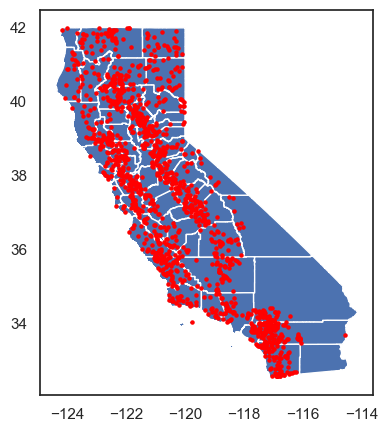

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))

county_boundaries.plot(ax=ax)
fire_incidents.plot(ax=ax, color='red', markersize=5);

### Zbiór danych **California Fire Perimeters**

Dane w zbiorze **California Fire Incidents** zawierają jedynie informacje o wielkości powierzchni objętej danym pożarem, natomiast nie jest udokumentowane, jaka konkretna powierzchnia podległa spaleniu. W celu wyznaczenia precyzyjnych wartości powierzchni objętych pożarami z podziałem na hrabstwa i ich dalszej analizy zostanie wykorzystany dodatkowy zbiór danych: **California Fire Perimeters (all)** - https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all, zwany dalej **California Fire Perimeters**.

#### Opis zbioru danych

Ze zbioru danych **California Fire Perimeters** wykorzystane zostaną następujące atrybuty:
- **YEAR_** — Rok wystąpienia pożaru.
- **FIRE_NAME** — Nazwa pożaru.
- **ALARM_DATE** — Data i czas zgłoszenia pożaru.
- **CONT_DATE** — Data i czas całkowitego ugaszenia pożaru.
- **geometry** — Całkowita powierzchnia objęta pożarem.

Pozostałe atrybuty nie będą wykorzystywane w przeprowadzanych analizach, więc zostaną usunięte.

In [15]:
fire_perimeters = gpd.read_file('data/California_Fire_Perimeters.geojson')

print(fire_perimeters.crs)
fire_perimeters.head()

EPSG:4326


,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,geometry
0,1,2023.0,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17 00:00:00+00:00,2023-06-17 00:00:00+00:00,5.0,...,5.729125,None,None,{7985848C-0AC2-4BA4-8F0E-29F778652E61},None,None,2020.0,41407.839844,1247.166034,"POLYGON ((-122.91148 41.53201, -122.9115 41.53..."
1,2,2023.0,CA,LRA,BTU,KAISER,00010225,2023-06-02 00:00:00+00:00,2023-06-02 00:00:00+00:00,5.0,...,13.602380,None,None,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},None,None,2020.0,93455.878906,1285.514550,"POLYGON ((-121.96182 39.8297, -121.96181 39.82..."
2,3,2023.0,CA,CDF,AEU,JACKSON,00017640,2023-07-01 00:00:00+00:00,2023-07-02 00:00:00+00:00,2.0,...,27.814460,None,None,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},None,None,2020.0,183028.500000,2697.587429,"POLYGON ((-120.90644 38.29537, -120.90397 38.2..."
3,4,2023.0,CA,CDF,AEU,CARBON,00018821,2023-07-11 00:00:00+00:00,2023-07-11 00:00:00+00:00,9.0,...,58.760230,None,None,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},None,None,2020.0,388221.953125,2548.738779,"POLYGON ((-120.98579 38.44344, -120.98488 38.4..."
4,5,2023.0,CA,CDF,AEU,LIBERTY,00018876,2023-07-11 00:00:00+00:00,2023-07-12 00:00:00+00:00,14.0,...,70.979000,None,None,{F83F70A4-07A7-40B8-BD51-10CCC1C30D63},None,None,2020.0,466456.007812,5106.936526,"POLYGON ((-120.98886 38.25035, -120.98895 38.2..."


Analiza dotyczy lat 2013-2020, więc dane z innych lat zostaną odrzucone.

In [16]:
fire_perimeters = fire_perimeters[['YEAR_', 'FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'geometry']]
fire_perimeters_2013_to_2020 = fire_perimeters.query("YEAR_ > 2012 & YEAR_ < 2021")

fire_perimeters_2013_to_2020.head()

,YEAR_,FIRE_NAME,ALARM_DATE,CONT_DATE,geometry
978,2020.0,NELSON,2020-06-18 00:00:00+00:00,2020-06-23 00:00:00+00:00,"POLYGON ((-121.34842 38.88999, -121.34836 38.8..."
979,2020.0,AMORUSO,2020-06-01 00:00:00+00:00,2020-06-04 00:00:00+00:00,"POLYGON ((-121.35276 38.82039, -121.35269 38.8..."
980,2020.0,ATHENS,2020-08-10 00:00:00+00:00,2020-08-11 00:00:00+00:00,"POLYGON ((-121.33335 38.84558, -121.33312 38.8..."
981,2020.0,FLEMING,2020-03-31 00:00:00+00:00,2020-04-01 00:00:00+00:00,"POLYGON ((-121.27318 38.96308, -121.27306 38.9..."
982,2020.0,MELANESE,2020-04-14 00:00:00+00:00,2020-04-19 00:00:00+00:00,"POLYGON ((-121.30067 39.48714, -121.30042 39.4..."


## Analiza i wizualizacja

### Obliczenie całkowitej spalonej powierzchni w poszczególnych hrabstwach w latach 2013-2020.

Aby przypisać powierzchnię pożarów do poszczególnych hrabstw, zostaną one podzielone zgodnie z granicami hrabstw zawartymi w zbiorze **California County Boundaries**.

In [17]:
fires_in_counties = gpd.overlay(fire_perimeters_2013_to_2020, county_boundaries, how='intersection')

fires_in_counties.head()

,YEAR_,FIRE_NAME,ALARM_DATE,CONT_DATE,COUNTY_NAME,geometry
0,2020.0,NELSON,2020-06-18 00:00:00+00:00,2020-06-23 00:00:00+00:00,Placer,"POLYGON ((-121.34836 38.89, -121.34831 38.8900..."
1,2020.0,AMORUSO,2020-06-01 00:00:00+00:00,2020-06-04 00:00:00+00:00,Placer,"POLYGON ((-121.35269 38.82031, -121.35265 38.8..."
2,2020.0,ATHENS,2020-08-10 00:00:00+00:00,2020-08-11 00:00:00+00:00,Placer,"POLYGON ((-121.33312 38.84563, -121.33291 38.8..."
3,2020.0,FLEMING,2020-03-31 00:00:00+00:00,2020-04-01 00:00:00+00:00,Placer,"POLYGON ((-121.27306 38.96313, -121.27293 38.9..."
4,2020.0,MELANESE,2020-04-14 00:00:00+00:00,2020-04-19 00:00:00+00:00,Yuba,"POLYGON ((-121.30042 39.48712, -121.30026 39.4..."


Następnie należy obliczyć łączną powierzchnię spalonych terenów w każdym hrabstwie na podstawie danych geograficznych o występujących tam pożarach.

Wynik zostanie przedstawiony w dwóch formach:
- jako powierzchnia w kilometrach kwadratowych,
- jako procent całkowitej powierzchni hrabstwa.

In [18]:
fires_in_counties['SquareKilometersBurned'] = fires_in_counties.to_crs("EPSG:32610").geometry.area / 1_000_000
area_burned_by_county = fires_in_counties.groupby("COUNTY_NAME")["SquareKilometersBurned"].sum()

county_boundaries = county_boundaries.dissolve(by='COUNTY_NAME')

county_boundaries['SquareKilometersBurned'] = area_burned_by_county
county_boundaries['TotalAreaSquareKilometers'] = county_boundaries.to_crs("EPSG:32610").geometry.area / 1_000_000
county_boundaries['PercentAreaBurned'] = county_boundaries['SquareKilometersBurned'] / county_boundaries['TotalAreaSquareKilometers'] * 100

county_boundaries.reset_index(inplace=True)

county_boundaries.head()

,COUNTY_NAME,geometry,SquareKilometersBurned,TotalAreaSquareKilometers,PercentAreaBurned
0,Alameda,"POLYGON ((-122.27125 37.90503, -122.27024 37.9...",112.964585,2128.233888,5.307903
1,Alpine,"POLYGON ((-119.58667 38.7142, -119.58653 38.71...",194.336553,1921.383912,10.114405
2,Amador,"POLYGON ((-120.07246 38.70276, -120.07249 38.6...",22.828389,1569.866741,1.454161
3,Butte,"POLYGON ((-121.07661 39.59729, -121.07945 39.5...",1380.192639,4341.440326,31.791123
4,Calaveras,"POLYGON ((-120.01792 38.43586, -120.01788 38.4...",315.587729,2683.327601,11.761059


Statystyki obliczonych wartości:

In [19]:
county_boundaries[['SquareKilometersBurned', 'TotalAreaSquareKilometers', 'PercentAreaBurned']].describe()

,SquareKilometersBurned,TotalAreaSquareKilometers,PercentAreaBurned
count,57.000000,58.000000,57.000000
mean,690.524550,7102.302675,12.548387
std,700.521592,8123.672094,13.414340
min,1.971961,273.332548,0.016789
25%,111.262901,2537.089804,3.002202
50%,429.517212,4039.411049,8.673266
75%,1046.879319,8969.743890,17.856604
max,3011.991331,52543.752116,65.255617


#### Wizualizacja obliczonych wartości

Wyliczone wartości zostaną podzielone na określone przedziały oraz zwizualizowane za pomocą map statycznych.

In [20]:
county_boundaries.fillna(0, inplace=True)

max_sq_km = county_boundaries['SquareKilometersBurned'].max()
sq_km_bins = np.arange(500, max_sq_km, 500)

max_percent = county_boundaries['PercentAreaBurned'].max()
percent_bins = np.arange(10, max_percent, 10)

square_kilometers_burned_classifier = mc.UserDefined.make(bins=sq_km_bins)
percentage_area_burned_classifier = mc.UserDefined.make(bins=percent_bins)

county_boundaries = county_boundaries.assign(
    SquareKilometersBurnedClass=county_boundaries[['SquareKilometersBurned']].apply(square_kilometers_burned_classifier),
    PercentAreaBurnedClass=county_boundaries[['PercentAreaBurned']].apply(percentage_area_burned_classifier)
)

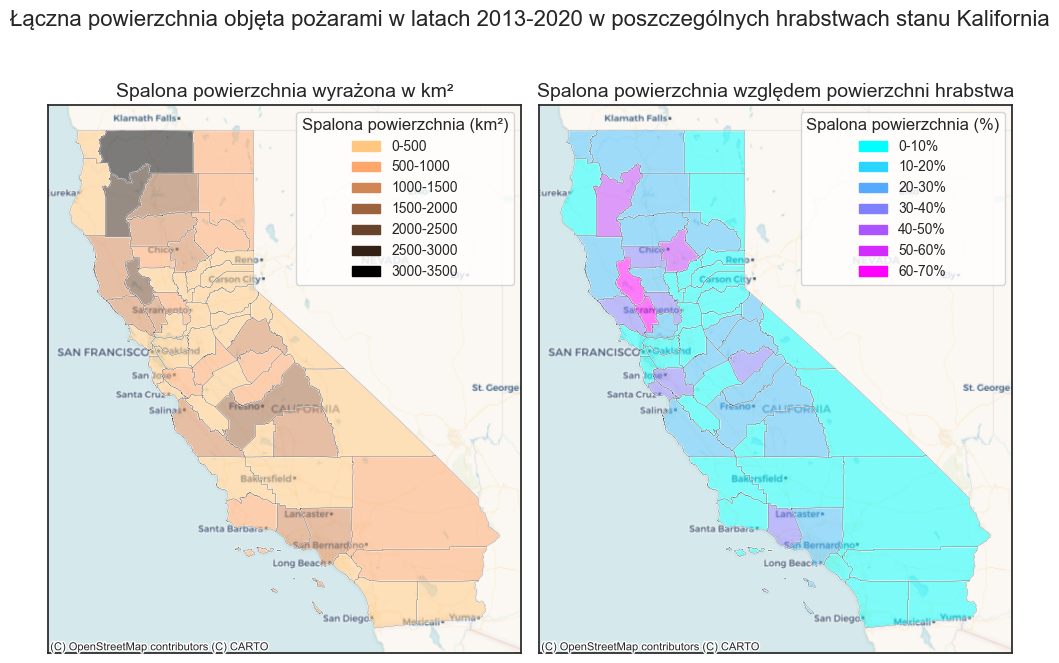

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

county_boundaries.plot(
    column='SquareKilometersBurnedClass',
    categorical=True,
    legend=False,
    alpha=0.5,
    cmap='copper_r',
    ax=axes[0]
)
axes[0].set_title("Spalona powierzchnia wyrażona w km²", fontsize=14)

county_boundaries.plot(
    column='PercentAreaBurnedClass',
    categorical=True,
    legend=False,
    alpha=0.5,
    cmap='cool',
    ax=axes[1]
)
axes[1].set_title("Spalona powierzchnia względem powierzchni hrabstwa", fontsize=14)

for ax in axes:
    county_boundaries.boundary.plot(ax=ax, color='black', linewidth=0.1)
    ctx.add_basemap(ax, crs=county_boundaries.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

sq_km_labels = ([f"{0}-{int(sq_km_bins[0])}"] +
                [f"{int(sq_km_bins[i])}-{int(sq_km_bins[i+1])}" for i in range(len(sq_km_bins) - 1)] +
                [f"{int(sq_km_bins[-1])}-3500"])
sq_km_patches = [mpatches.Patch(color=plt.cm.copper_r(i / len(sq_km_bins)), label=label) for i, label in enumerate(sq_km_labels)]
axes[0].legend(handles=sq_km_patches, title="Spalona powierzchnia (km²)", fontsize=10, title_fontsize=12)

percent_labels = ([f"0-{int(percent_bins[0])}%"] +
                  [f"{int(percent_bins[i])}-{int(percent_bins[i+1])}%" for i in range(len(percent_bins) - 1)] +
                  [f"{int(percent_bins[-1])}-70%"])
percent_patches = [mpatches.Patch(color=plt.cm.cool(i / len(percent_bins)), label=label) for i, label in enumerate(percent_labels)]
axes[1].legend(handles=percent_patches, title="Spalona powierzchnia (%)", fontsize=10, title_fontsize=12)

plt.suptitle("Łączna powierzchnia objęta pożarami w latach 2013-2020 w poszczególnych hrabstwach stanu Kalifornia", y=0.85, fontsize=16)

plt.tight_layout()
plt.show()

### Mapa interaktywna

Na potrzeby mapy interaktywnej, zostaną wygenerowane pomocnicze wykresy obrazujące liczbę pożarów w poszczególnych hrabstwach w latach między 2013 a 2020.

In [22]:
os.makedirs('plots', exist_ok=True)

for county in county_boundaries['COUNTY_NAME']:
    years = range(2013, 2021)
    fires_in_counties_count = fires_in_counties.query(f"COUNTY_NAME == '{county}'").groupby("YEAR_").size().reindex(years, fill_value=0)

    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(x=fires_in_counties_count.index, y=fires_in_counties_count.values, ax=ax)
    ax.set_title(f"Number of Fires in {county} County (2013-2020)", fontsize=17)
    ax.set_xlabel("Year", fontsize=15)
    ax.set_ylabel("Number of Fires", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.savefig(f'plots/number_of_fires_{county}.png', bbox_inches='tight')
    plt.close()

#### Warstwy i elementy mapy

Mapa interaktywna składa się z następujących części:
- **Wildfires** — Lokalizacje pojedynczych pożarów.
- **Wildfires Heat Map** — Mapa ciepła pojedynczych pożarów.
- **County Boundaries** — Granice hrabstw stanu Kalifornia.
- **Resources** — Lokalizacje, w których wykorzystano zasoby:
    - *Human Resources* — Zasoby ludzkie.
    - *Other Resources* — Zasoby sprzętowe.
- **Losses** — Lokalizacje, w których nastąpiły straty:
    - *Victims* — Straty w ludziach.
    - *Structures* — Straty w budynkach.

In [23]:
from folium import FeatureGroup, Icon, Marker
from folium.plugins import HeatMap, MarkerCluster, OverlappingMarkerSpiderfier, TreeLayerControl


m = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='cartodb voyager')


marker_group = FeatureGroup(name='Wildfires',show=False).add_to(m)

for _, row in fire_incidents.iterrows():
    Marker(
        location=(row.geometry.y, row.geometry.x),
        icon=Icon(color='red', icon='fa-duotone fa-solid fa-fire-flame-curved', prefix='fa'),
        popup=folium.Popup(f"Fire Name: <b>{row['Name']}</b><br>"
                           f"Date: <b>{row['Started']}</b>", max_width=300)
    ).add_to(marker_group)


heatmap_data = pd.concat([fire_incidents.geometry.y, fire_incidents.geometry.x], axis=1).values.tolist()

HeatMap(heatmap_data, name='Wildfires Heat Map', show=False, radius=10, blur=10, max_zoom=10, min_opacity=0.6).add_to(m)


fg_resources = FeatureGroup(name="Resources", control=False).add_to(m)

resource_clusters = {
    'Human Resources': MarkerCluster(name='Human Resources', show=False).add_to(fg_resources),
    'Other Resources': MarkerCluster(name='Other Resources', show=False).add_to(fg_resources)
}

resource_icons = {
    'Human Resources': 'fa-solid fa-person',
    'Other Resources': 'fa-solid fa-truck'
}

fg_losses = FeatureGroup(name="Losses", control=False).add_to(m)

losses_clusters = {
    'Victims': MarkerCluster(name='Victims', show=False).add_to(fg_losses),
    'Structures': MarkerCluster(name='Structures', show=False).add_to(fg_losses)
}

losses_icons = {
    'Victims': 'fa-solid fa-user-injured',
    'Structures': 'fa-solid fa-house-crack'
}

human_resources = ['CrewsInvolved', 'PersonnelInvolved']
other_resources = ['Dozers', 'AirTankers', 'Engines', 'Helicopters', 'WaterTenders']
victim_losses = ['Injuries', 'Fatalities']
structure_losses = ['StructuresDamaged', 'StructuresDestroyed', 'StructuresThreatened']


for _, row in fire_incidents.iterrows():
    for category, cluster in resource_clusters.items():
        relevant_resources = [res for res in (human_resources if category == 'Human Resources' else other_resources) if not pd.isna(row[res]) and row[res] != 0]
        if relevant_resources:
            resources = [f"{res}: <b>{int(row[res])}</b>" for res in relevant_resources]
            popup_content = (f"<br>".join(resources) +
                             f"<br>Date: <b>{row['Started']}</b>")
            folium.Marker(
                location=(row.geometry.y, row.geometry.x),
                icon=folium.Icon(color='blue', icon=resource_icons[category], prefix='fa'),
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(cluster)

    for category, cluster in losses_clusters.items():
        if category == 'Victims' and any(not pd.isna(row[loss]) and row[loss] != 0 for loss in victim_losses):
            losses = [f"{loss}: <b>{int(row[loss])}</b>" for loss in victim_losses if not pd.isna(row[loss]) and row[loss] != 0]
            popup_content = (f"<br>".join(losses) +
                             f"<br>Date: <b>{row['Started']}</b>")
            folium.Marker(
                location=(row.geometry.y, row.geometry.x),
                icon=folium.Icon(color='black', icon=losses_icons[category], prefix='fa'),
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(cluster)

        if category == 'Structures' and any(not pd.isna(row[loss]) and row[loss] != 0 for loss in structure_losses):
            structures = [f"{loss}: <b>{int(row[loss])}</b>" for loss in structure_losses if not pd.isna(row[loss]) and row[loss] != 0]
            popup_content = (f"<br>".join(structures) +
                             f"<br>Date: <b>{row['Started']}</b>")
            folium.Marker(
                location=(row.geometry.y, row.geometry.x),
                icon=folium.Icon(color='black', icon=losses_icons[category], prefix='fa'),
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(cluster)


overlay_tree = {
    "label": "<b>Resources and Losses</b>",
    "children": [
        {
            "label": "<b>Resources</b>",
            "select_all_checkbox": True,
            "collapsed": True,
            "children": [
                {"label": label, "layer": layer} for label, layer in resource_clusters.items()
            ]
        }, {
            "label": "<b>Losses</b>",
            "select_all_checkbox": True,
            "collapsed": True,
            "children": [
                {"label": label, "layer": layer} for label, layer in losses_clusters.items()
            ]
        }
    ]
}


county_boundaries_group = FeatureGroup(name='California Counties', show=True).add_to(m)

for _, row in county_boundaries.iterrows():
    geo_j = folium.GeoJson(
        row.geometry,
        style_function=lambda x: {'color': 'black', 'fillColor': 'orange', 'fillOpacity': 0.2, 'weight': 0.2},
        tooltip=f"County: <b>{row['COUNTY_NAME']}</b><br><i>Press for more info</i>"
    )

    with open(f'plots/number_of_fires_{row['COUNTY_NAME']}.png', 'rb') as image_file:
        img_base64 = base64.b64encode(image_file.read()).decode('utf-8')
        img_html = f'<img src="data:image/jpeg;base64,{img_base64}" width="500" height="300">'

    folium.Popup(img_html).add_to(geo_j)
    geo_j.add_to(county_boundaries_group)

county_boundaries_group.add_to(m)


oms = OverlappingMarkerSpiderfier(
    keep_spiderfied=True, nearby_distance=30, leg_weight=2.0
)
oms.add_to(m)


folium.LayerControl(collapsed=False).add_to(m)

TreeLayerControl(
    overlay_tree=overlay_tree,
    collapsed=False
).add_to(m)

os.makedirs('folium_maps', exist_ok=True)

m.save('folium_maps/interactive_map.html')

### Mapa interaktywna obrazująca przebieg pożarów w czasie

In [24]:
fire_perimeters_timestamped = fire_perimeters_2013_to_2020.rename(columns={'FIRE_NAME': 'name', 'ALARM_DATE': 'start', 'CONT_DATE': 'end'})
fire_perimeters_timestamped = fire_perimeters_timestamped[['name', 'start', 'end', 'geometry']]

fire_perimeters_timestamped['name'] = fire_perimeters_timestamped['name'].apply(lambda x: x.title() + " Fire" if x is not None else '')
fire_perimeters_timestamped['start'] = fire_perimeters_timestamped['start'].dt.strftime('%Y-%m-%dT%H:%M:%S')
fire_perimeters_timestamped['end'] = fire_perimeters_timestamped['end'].dt.strftime('%Y-%m-%dT%H:%M:%S')

fire_perimeters_timestamped = fire_perimeters_timestamped.query(
    "(start >= '2013-01-01') and (end <= '2020-12-31')"
)

In [25]:
from folium import JsCode, GeoJsonTooltip
from folium.plugins import Timeline, TimelineSlider


m_timeline = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='cartodb voyager')


timeline = Timeline(
    fire_perimeters_timestamped.to_json(),
    style=JsCode("""
        function (data) {
            return {
                stroke: true,
                color: "red",
                weight: 3,
                fillOpacity: 0.5
            };
        }
    """)
).add_to(m_timeline)

GeoJsonTooltip(fields=['name', 'start', 'end'], labels=True).add_to(timeline)


TimelineSlider(
    auto_play=False,
    show_ticks=True,
    enable_keyboard_controls=True,
    playback_duration=100000
).add_timelines(timeline).add_to(m_timeline)


m_timeline.save('folium_maps/interactive_map_timeline.html')

### Optymalny rozkład dodatkowych placówek pożarniczych na podstawie zużytych zasobów

Aby określić najlepsze lokalizacje dla nowych placówek straży pożarnej, zastosowane zostanie podejście oparte na problemie p-mediany. Problem ten polega na znalezieniu *p* optymalnych punktów (w tym przypadku placówek pożarniczych), które minimalizują sumę ważonych odległości między wszystkimi punktami zapotrzebowania a najbliższą im placówką.

Uproszczony przebieg użytego algorytmu:

1. Obliczenie wag dla punktów wykorzystania zasobów – wyznaczenie każdej wagi jako sumy zasobów ludzkich i sprzętowych użytych w danej lokalizacji.
2. Wyznaczenie macierzy odległości – określenie dystansu euklidesowego między każdą parą lokalizacji.
3. Optymalizacja lokalizacji – wybranie jako wyznaczonych placówek p punktów, przy których całkowita ważona odległość między poszczególnymi lokalizacjami a najbliższą im placówką jest najmniejsza.

Przygotowanie danych i przykładowe rozwiązanie problemu p-mediany dla 10 placówek pomocniczych.

In [26]:
fire_incidents_resources = fire_incidents.assign(
    TotalResources=fire_incidents[['Dozers', 'AirTankers', 'CrewsInvolved', 'Engines', 'Helicopters', 'PersonnelInvolved', 'WaterTenders']].sum(axis=1)
)

fire_incidents_resources = fire_incidents_resources.query("TotalResources > 0")

In [27]:
resource_coords = np.array([(point.x, point.y) for point in fire_incidents_resources.geometry])
resource_weights = fire_incidents_resources['TotalResources'].to_numpy()

p = 10
n = len(resource_coords)
dist_matrix = cdist(resource_coords, resource_coords)


solver = pywraplp.Solver.CreateSolver('SCIP')


# Zmienne definiujące przypisanie punktów do placówek (x) oraz aktywność placówek (y)
x = [[solver.BoolVar(f'x[{i},{j}]') for j in range(n)] for i in range(n)]
y = [solver.BoolVar(f'y[{j}]') for j in range(n)]


# Funkcja celu

objective = solver.Objective()
for i in range(n):
    for j in range(n):
        objective.SetCoefficient(x[i][j], dist_matrix[i, j] * resource_weights[i])
objective.SetMinimization()


# Ograniczenia

# Jeden punkt może być przydzielony do maksymalnie jednej placówki
for i in range(n):
    solver.Add(sum(x[i][j] for j in range(n)) == 1)

# Jeżeli punkt jest przydzielony do danej placówki, musi ona być aktywna
for i in range(n):
    for j in range(n):
        solver.Add(x[i][j] <= y[j])

# Łączna liczba aktywnych placówek musi być równa p
solver.Add(sum(y[j] for j in range(n)) == p)


solver.Solve()


fire_stations_indices = [j for j in range(n) if y[j].solution_value() == 1]
proposed_locations = gpd.GeoSeries(shapely.Point(x, y) for x, y in resource_coords[fire_stations_indices])

#### Wizualizacja rozwiązania problemu

Rozwiązanie zostanie zwizualizowane za pomocą mapy statycznej z nałożonymi lokalizacjami, w których zostały wykorzystane zasoby (ich rozmiar dostosowany na podstawie liczby wykorzystanych zasobów) oraz wyznaczonymi lokalizacjami nowych placówek pożarniczych.

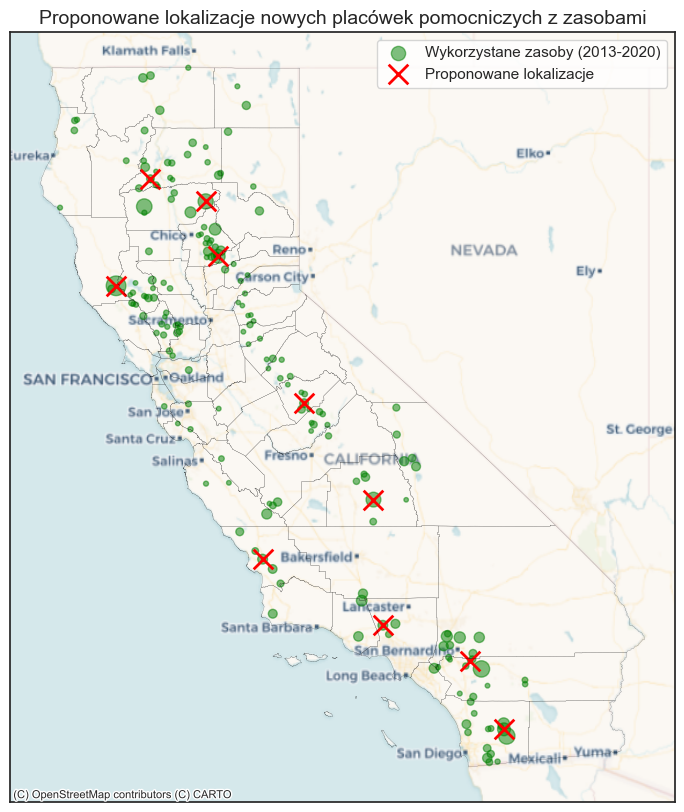

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

scaler = MinMaxScaler(feature_range=(10, 200))
marker_sizes = scaler.fit_transform(
    fire_incidents_resources[['TotalResources']]
)

fire_incidents_resources.plot(ax=ax, color='green', markersize=marker_sizes, alpha=0.5, label='Wykorzystane zasoby (2013-2020)')
proposed_locations.plot(ax=ax, color='red', marker='x', markersize=200, linewidth=2, label='Proponowane lokalizacje')
county_boundaries.boundary.plot(ax=ax, color='black', linewidth=0.1)
ctx.add_basemap(ax, crs=county_boundaries.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_title('Proponowane lokalizacje nowych placówek pomocniczych z zasobami', fontsize=14)

plt.legend()
plt.show()

### Analiza finansowania systemu pożarnictwa w hrabstwach Kalifornii oraz ocena zapotrzebowania na dodatkowe środki budżetowe.

Celem tej części projektu jest analiza wydatków hrabstw Kalifornii na pożarnictwo w latach 2013-2020 oraz ocena zapotrzebowania na budżet w przyszłości, biorąc pod uwagę dotychczasowe dofinansowanie oraz powierzchnię terenów objętych pożarami. W tym celu przetwarzamy dane budżetowe, normalizujemy wartości oraz tworzymy klasyfikację hrabstw pod względem zapotrzebowania na fundusze. Efektem jest wizualizacja na mapie, która umożliwia identyfikację obszarów wymagających zwiększonego finansowania.

Aby określić, jaki budżet został przeznaczony na działania związane z pożarami w latach 2013-2020 w poszczególnych hrabstwach stanu Kalifornia, zostanie wykorzystany zbiór danych udostępniony na portalu data.ca.gov: **County - Expenditure** - https://data.ca.gov/dataset/county-expenditures/resource/b2a575e1-d907-433b-80b1-843d75c66f3d?inner_span=True, zwany dalej **California County Expenditures**.

Ze zbioru danych **California County Expenditures** wykorzystane zostaną następujące atrybuty:

- **Entity Name** — Nazwa hrabstwa.
- **Fiscal Year** — Rok w którym dana sum z budżetu została przekazana.
- **Subcategory 1** — Podkategoria, na podstawie której stwierdzamy czy dana część budżetu została przeznaczona na walkę z pożarami.
- **Values** — Przekazana suma.

Pozostałe atrybuty nie będą wykorzystywane w przeprowadzanych analizach, więc zostaną usunięte.

In [29]:
county_expenditures = pd.read_csv('data/California_County_Expenditures.csv')

county_expenditures.head()

,_id,Entity Name,Fiscal Year,Type,Form/Table,Category,Subcategory 1,Subcategory 2,Line Description,Values,Zip Code,Estimated Population,Area in Sq. Miles,Row Number
0,1,Alameda,2016,Expenditures,AIRPORT_ENTERPRISE,Airport Activity/Enterprise,Operating Expenses,Administration,Administration,0,94612,1627865,825,158004
1,2,Alameda,2016,Expenditures,AIRPORT_ENTERPRISE,Airport Activity/Enterprise,Operating Expenses,Maintenance and Operation,Landing Areas_Maintenance and Operation,0,94612,1627865,825,158003
2,3,Alameda,2016,Expenditures,AIRPORT_ENTERPRISE,Airport Activity/Enterprise,Operating Expenses,Maintenance and Operation,Terminal Buildings and Areas_Maintenance and O...,0,94612,1627865,825,158002
3,4,Alameda,2016,Expenditures,AIRPORT_ENTERPRISE,Airport Activity/Enterprise,Operating Expenses,Maintenance and Operation,Other Buildings and Areas_Maintenance and Oper...,0,94612,1627865,825,158001
4,5,Alameda,2016,Expenditures,AIRPORT_ENTERPRISE,Airport Activity/Enterprise,Operating Expenses,Maintenance and Operation,General Shops and Equipment_Maintenance and Op...,0,94612,1627865,825,158000


In [30]:
county_expenditures = county_expenditures[['Entity Name', 'Fiscal Year', 'Subcategory 1', 'Values']]

Filtrowanie danych – wybór kolumn i selekcja wydatków na pożarnictwo. Grupowanie danych.

In [31]:
county_expenditures_filtered = county_expenditures[
    (county_expenditures['Subcategory 1'].str.contains('Fire', case=False, na=False)) &
    (county_expenditures['Fiscal Year'].between(2013, 2020))
]
county_expenditures_filtered_grouped = county_expenditures_filtered[["Entity Name", "Values"]].groupby('Entity Name').sum(numeric_only=True)

county_boundaries = county_boundaries.merge(
    county_expenditures_filtered_grouped,
    left_on='COUNTY_NAME',
    right_index=True,
    how='left'
)

In [32]:
county_boundaries[['COUNTY_NAME', 'Values', 'SquareKilometersBurned']].head()

,COUNTY_NAME,Values,SquareKilometersBurned
0,Alameda,267382409.0,112.964585
1,Alpine,3857547.0,194.336553
2,Amador,13188805.0,22.828389
3,Butte,133417692.0,1380.192639
4,Calaveras,2147971.0,315.587729


Obliczenie współczynnika zapotrzebowania na budżet pożarniczy na postawie całkowitego spalonego obszaru oraz przyznanych w przeszłości funduszy. Dane o spalonych terenach i wydatkach są normalizowane, aby były porównywalne. Wagi dla cech są wyznaczone na podstawie ich odchylenia standardowego, gdzie większe odchylenie standardowe danej cechy oznacza większy jej wpływ na wynik.

In [33]:
scaler_burned = MinMaxScaler()
scaler_values = MinMaxScaler()

county_boundaries['Normalized_SquareKilometersBurned'] = scaler_burned.fit_transform(
    county_boundaries[['SquareKilometersBurned']]
)
county_boundaries['Normalized_Values'] = scaler_values.fit_transform(
    county_boundaries[['Values']]
)

std_square_kilometers = county_boundaries['Normalized_SquareKilometersBurned'].std()
std_values = county_boundaries['Normalized_Values'].std()

total_std = std_square_kilometers + std_values
w1 = std_square_kilometers / total_std
w2 = std_values / total_std

county_boundaries['DemandScore'] = (
    w1 * county_boundaries['Normalized_SquareKilometersBurned'] +
    (1 - w2) * (1 - county_boundaries['Normalized_Values'])
)

In [34]:
county_boundaries[['Values','DemandScore']].describe()

,Values,DemandScore
count,5.700000e+01,57.000000
mean,1.514822e+08,0.679415
std,4.147989e+08,0.161688
min,0.000000e+00,0.274325
25%,0.000000e+00,0.585724
50%,1.213717e+07,0.645315
75%,1.330244e+08,0.767858
max,2.480139e+09,1.162424


#### Wizualizacja wykonanej analizy oraz podziału budżetu z danych historycznych.

Wyliczone wartości zostaną podzielone na określone przedziały oraz zwizualizowane za pomocą map statycznych.

In [35]:
max_expenditure = county_boundaries['Values'].max()
expenditure_bins = np.arange(250_000_000, max_expenditure, 250_000_000)

max_demand = county_boundaries['DemandScore'].max()
demand_bins = np.arange(0.2, max_demand, 0.2)

expenditure_classifier = mc.UserDefined.make(bins=expenditure_bins)
demand_classifier = mc.UserDefined.make(bins=demand_bins)

county_boundaries = county_boundaries.assign(
    ExpenditureClass=county_boundaries[['Values']].apply(expenditure_classifier),
    DemandClass=county_boundaries[['DemandScore']].apply(demand_classifier)
)

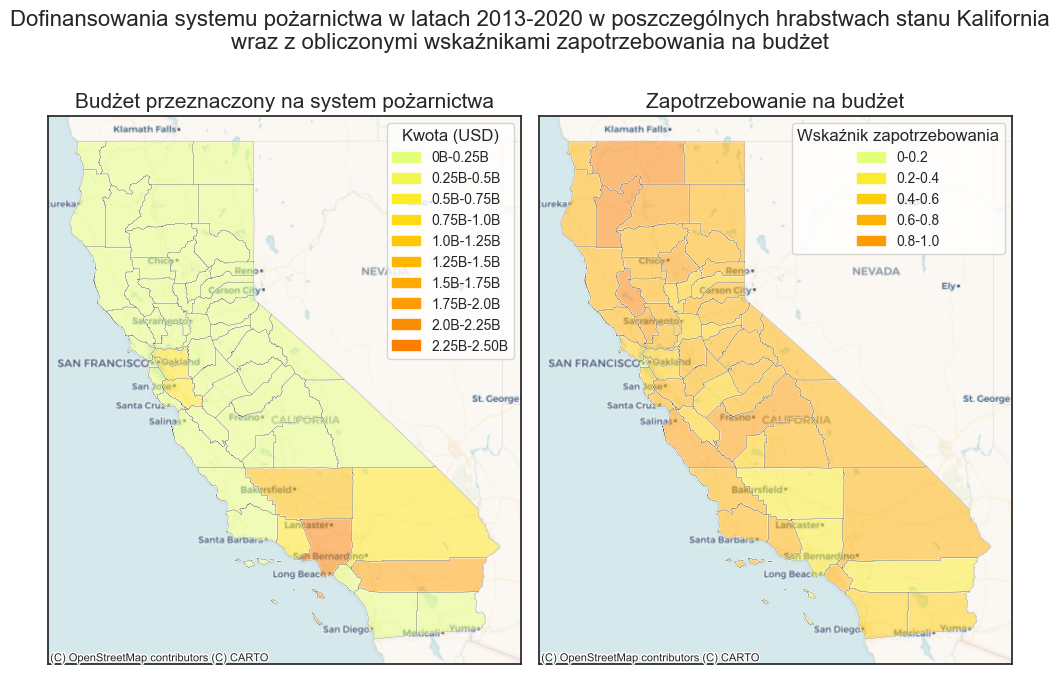

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

county_boundaries.plot(
    column='ExpenditureClass',
    categorical=True,
    legend=False,
    alpha=0.5,
    cmap='Wistia',
    ax=axes[0]
)
axes[0].set_title("Budżet przeznaczony na system pożarnictwa", fontsize=15)

county_boundaries.plot(
    column='DemandClass',
    categorical=True,
    legend=False,
    alpha=0.5,
    cmap='Wistia',
    ax=axes[1]
)
axes[1].set_title("Zapotrzebowanie na budżet", fontsize=15)

expenditure_labels = ([f"0B-{expenditure_bins[0] / 1_000_000_000}B"] +
                      [f"{int(expenditure_bins[i]) / 1_000_000_000}B-{int(expenditure_bins[i+1]) / 1_000_000_000}B" for i in range(len(expenditure_bins) - 1)] +
                      [f"{expenditure_bins[-1] / 1_000_000_000}B-2.50B"])
expenditure_patches = [mpatches.Patch(color=plt.cm.Wistia(i / len(expenditure_bins)), label=label) for i, label in enumerate(expenditure_labels)]
axes[0].legend(handles=expenditure_patches, title="Kwota (USD)", fontsize=10, title_fontsize=12)

demand_labels = ([f"0-{demand_bins[0]:.1f}"] +
                 [f"{demand_bins[i]:.1f}-{demand_bins[i+1]:.1f}" for i in range(len(demand_bins) - 1)])
demand_patches = [mpatches.Patch(color=plt.cm.Wistia(i / len(demand_bins)), label=label) for i, label in enumerate(demand_labels)]
axes[1].legend(handles=demand_patches, title="Wskaźnik zapotrzebowania", fontsize=10, title_fontsize=12)

for ax in axes:
    county_boundaries.boundary.plot(ax=ax, color='black', linewidth=0.1)
    ctx.add_basemap(ax, crs=county_boundaries.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.suptitle("Dofinansowania systemu pożarnictwa w latach 2013-2020 w poszczególnych hrabstwach stanu Kalifornia\n"
             "wraz z obliczonymi wskaźnikami zapotrzebowania na budżet", y=0.85, fontsize=16)

plt.tight_layout()
plt.show()

Przykładowe zastosowanie wskaźnika zapotrzebowania na budżet: zakładamy całkowity budżet w wysokości 10 miliardów USD, który zostanie podzielony między hrabstwa proporcjonalnie do ich wartości wskaźnika zapotrzebowania.

In [37]:
total_budget = 10_000_000_000 

county_boundaries['BudgetAllocation'] = (
    county_boundaries['DemandScore'] / county_boundaries['DemandScore'].sum()
) * total_budget

county_boundaries.dropna(subset=['BudgetAllocation', 'DemandScore'], inplace=True)

county_boundaries[['COUNTY_NAME','DemandScore', 'BudgetAllocation']].rename(
    columns={
        'COUNTY_NAME': 'Hrabstwo',
        'DemandScore': 'Wskaźnik Zapotrzebowania',
        'BudgetAllocation': 'Przydział Budżetu (USD)'
    }
).sort_values(by='Przydział Budżetu (USD)', ascending=False).style.format({'Przydział Budżetu (USD)': '{:,.2f}'})

,Hrabstwo,Wskaźnik Zapotrzebowania,Przydział Budżetu (USD)
46,Siskiyou,1.162424,"300,161,263.32"
52,Trinity,1.134979,"293,074,381.77"
16,Lake,1.015126,"262,125,948.68"
9,Fresno,0.946977,"244,528,536.20"
44,Shasta,0.922099,"238,104,706.49"
26,Monterey,0.850750,"219,680,766.01"
3,Butte,0.816822,"210,920,049.51"
27,Napa,0.807368,"208,478,782.41"
54,Tuolumne,0.799087,"206,340,360.11"
53,Tulare,0.796645,"205,709,722.59"
